# Lab Tutorial 05 (Solved)

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)

# Google Colab Setup
Before starting the tutorial, we need to run a few commands to set up our environment on Google Colab. To this end, make sure to have first gone through the **"Software setup guide"** document uploaded on Moodle. Also, if you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store the lab materials for this tutorial!), and follow the instructions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, we will update OpenCV. Note: don't worry about the following error:
```
ERROR: pip's dependency resolver...
```

In [ ]:
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 1.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


You can check that the correct version is now installed:

In [ ]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


Now recall the path in your Google Drive where you uploaded the lab materials, fill it in below and run the cell:

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision lab tutorials/Lab 05' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

If everything is working correctly then running the folowing cell should print the filenames from the lab materials folder:

```
['GregPen.avi', 'Lab_05.ipynb', 'Lab_05_Solved.ipynb']
```

# Introduction

In this lab tutorial, we will initially focus on **image matching**: first, we will attempt to do it using **manually-placed point correspondences** (as illustrated in a previous lecture), then we will automate the process using **interest points detection** and **feature matching**. In the second part of the tutorial, we will instead perform a **watershed segmentation** and implement a basic **object tracking** pipeline through segmentation.

# How to properly run the tutorial

To make the best out of the tutorial, you don't have to simply execute the cells and check the output. Instead, you have to **make an effort to understand each single line of code**. Browse the Internet looking for the official documentation for each command that you don't know, and modify the code to see if you properly understood its functionality.

In addition to this, while going through the notebook you will encounter code blocks that look like this:

```python
##############################################################################
# TODO: Write the equation for a line
##############################################################################
pass
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
```

These blocks constitute **tasks**, i.e. cells that require you to write some code to obtain a certain functionality. You should replace the `pass` statement with your own code and leave the blocks intact, like this:

```python
##############################################################################
# TODO: Instructions for what you need to do
##############################################################################
y = m * x + b
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
```

Don't worry if you don't get them straight away: this is why we're here anyway! Also, a separate version of this notebook with solved tasks will be released for your convenience on Moodle in the next few days.

# 1: Image matching with point correspondences

Image matching consists in **finding the transformation** (affine, projective, etc.) **that aligns one image to another**. In a previous lecture, we have seen that this task can be achieved by **manually selecting correponding points in the two images**.

Let's see how this can be done using `skimage`. First, let's load an image from the ones provided with the library, and apply an affine transformation to it to create the *warped* version. Our goal will be to find the transformation that aligns the warped image back to the original one.

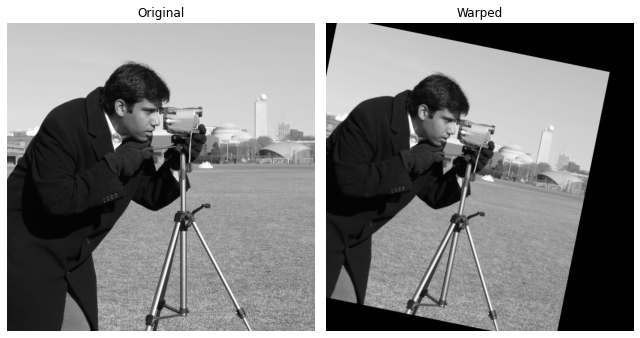

In [ ]:
from skimage import data, transform
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

img = data.camera()

# define custom affine transformation object
tform = transform.AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))

# warp image
img_warped = transform.warp(img, tform.inverse)

fig, ax = plt.subplots(1, 2, figsize=(9, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original'), ax[0].axis('off')
ax[1].imshow(img_warped, cmap='gray')
ax[1].set_title('Warped'), ax[1].axis('off')
fig.tight_layout()
plt.show()

At this point, we should use our pointer to identify the $(x, y$) coordinates of a series of (at least) 3 points in both images. For your convenience, I have already done this:

In [ ]:
img_points = np.array([[135, 365], [236, 150], [417, 129], [331, 304]])
img_warped_points = np.array([[73, 335], [205, 163], [365, 180], [260, 319]])

Let's see where these points are:

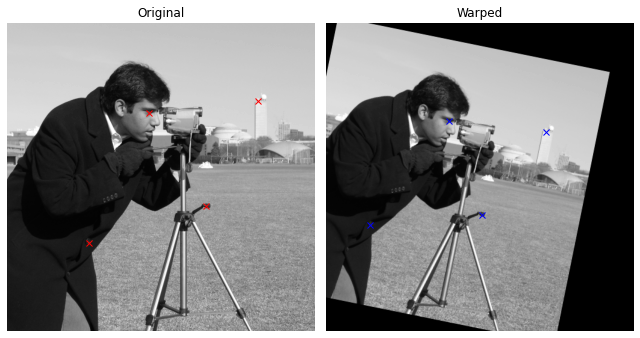

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original'), ax[0].axis('off')
ax[0].plot(img_points[:, 0], img_points[:, 1], 'xr')
ax[1].imshow(img_warped, cmap='gray')
ax[1].plot(img_warped_points[:, 0], img_warped_points[:, 1], 'xb')
ax[1].set_title('Warped'), ax[1].axis('off')
fig.tight_layout()
plt.show()

Notice how the points are usually picked in locations with easy-to-identify features (e.g. the cameraman's eye, the building's top) but technically they don't  have to be.

Now let's create an empty transformation object and use `skimage`'s `estimate` method to estimate the transformation from the point correspondences:

In [ ]:
tform2 = transform.AffineTransform()
tform2.estimate(img_points, img_warped_points)

True

We can now apply this transformation to the warped image, creating therefore the aligned version. Let's see how it compares to the original one:

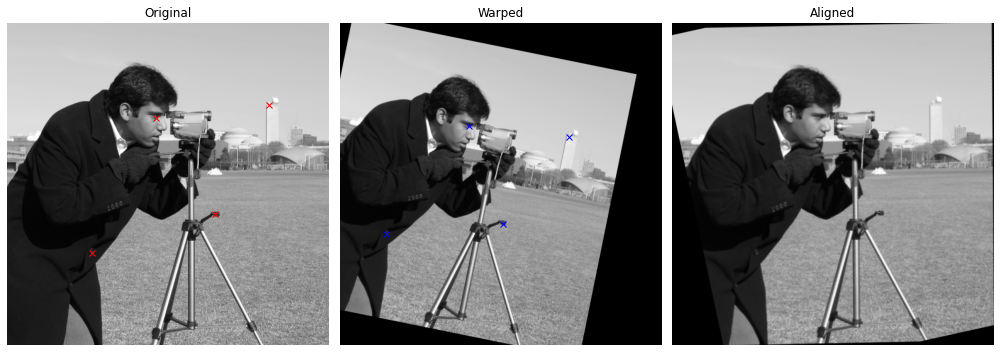

In [ ]:
img_aligned = transform.warp(img_warped, tform2)

fig, ax = plt.subplots(1, 3, figsize=(14, 6))
ax[0].imshow(img, cmap='gray'), ax[0].set_title('Original'), ax[0].axis('off')
ax[0].plot(img_points[:, 0], img_points[:, 1], 'xr')
ax[1].imshow(img_warped, cmap='gray'), ax[1].set_title('Warped'), ax[1].axis('off')
ax[1].plot(img_warped_points[:, 0], img_warped_points[:, 1], 'xb')
ax[2].imshow(img_aligned, cmap='gray'), ax[2].set_title('Aligned'), ax[2].axis('off')
fig.tight_layout()
plt.show()

Not bad, right?

We can also compare the parameters of both affine transformations directly:

In [ ]:
print("Affine transformation parameters for distortion = ", "\n", tform.params)
print("Affine transformation parameters for alignment = ", "\n", tform2.params)

Affine transformation parameters for distortion =  
 [[  0.88205992  -0.1788024   20.        ]
 [  0.1788024    0.88205992 -10.        ]
 [  0.           0.           1.        ]]
Affine transformation parameters for alignment =  
 [[  0.87949666  -0.1876834   24.19177605]
 [  0.19674903   0.89196037 -17.18515074]
 [  0.           0.           1.        ]]


As you can see, the two matrices are very similar, which confirms the good job done by our image matching algorithm.

# 2: Image matching with feature descriptors

It goes without saying that having to manually pick point correpondences in images is not a very convenient approach for image matching, especially if we are dealing with more than just a few images.

Thankfully, as we have seen in today's lecture, we can perform the same task by means of **interest point detection** and **feature descriptors**. This approach is essentially based on the following steps:

- Automatically detect interest points (or keypoints) in both images independently
- Compute feature descriptors for each of these points
- Find point correspondences between the two sets of points (by comparing their feature descriptors
- Estimate the transformation (just as we did with manually-selected correspondences)

Let's see how we can do this using `OpenCV`. First, let's load again our cameraman image (note that we will need to cast it to uint8 in order to use `OpenCV`'s functions) and apply a warping to corrupt it:

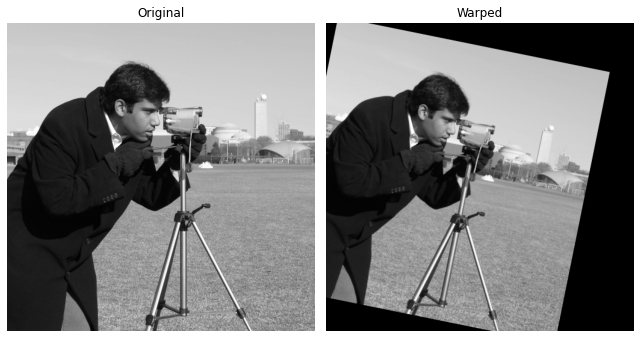

In [ ]:
from skimage import data, img_as_ubyte, transform
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = img_as_ubyte(data.camera())  # Format required by OpenCV

# warp synthetic image (default: scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
tform = transform.AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
img_warped = img_as_ubyte(transform.warp(img, tform.inverse))

fig, ax = plt.subplots(1, 2, figsize=(9, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original'), ax[0].axis('off')
ax[1].imshow(img_warped, cmap='gray')
ax[1].set_title('Warped'), ax[1].axis('off')
fig.tight_layout()
plt.show()

To identify interest points and compute feature descriptors, **we will make use of SIFT**, which is arguably the most famous approach for this task. The latest verions of OpenCV have dedicated functions for this (previous ones did not due to SIFT's patent, this is why we had to update the library at the beginning of the tutorial). Specifically, we will identify interest points and compute the descriptors with just one method called `detectAndCompute`:

In [ ]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Identify the keypoints and compute the descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img, None)
kp2, des2 = sift.detectAndCompute(img_warped, None)

Now it's time to perform the matching: to do this, OpenCV provides the convenient `BFMatcher` object, where we can specify also the type of metric used to perform the comparisons. Make sure to have a look at the documentation online to understand how to use this object and its methods.

In [ ]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

Then, we can sort the matches between the two sets of keypoints, and keep only a portion of them (trying to discard spurious and unreliable matches):

In [ ]:
# Sort matches based on differences between matched descriptors
matches = sorted(matches, key=lambda x: x.distance)

# Remove bottom-half of the matches
good_match_ratio = 0.5
numGoodMatches = int(len(matches) * good_match_ratio)
matches = matches[:numGoodMatches]

`OpenCV` provides a very handy function to also plot the matches between the two sets of points:

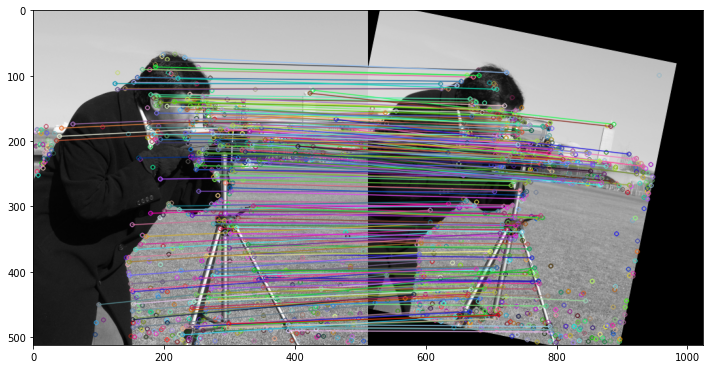

In [ ]:
# Show matches
fig = plt.figure(figsize=(12, 9))
imMatches = cv2.drawMatches(img, kp1, img_warped, kp2, matches, None)
plt.imshow(imMatches)
plt.show()

Notice the amount of keypoints that are being matched: the more reliable matches, the better to accurately estimate the final transformation.

Now, using the matching information, we can create two *ordered* arrays with the point coordinates for the two sets of points. Specifically, the rows of `points1` and of `points2` will consist of the $(x, y)$ coordinates of matched points, just as we did in the previous section. This is needed to estimate the alignment transformation.

In [ ]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

We can now use `OpenCV`'s `findHomography` function to estimate the transformation parameters. This function allows to also use RANSAC (of which we talked about in the lecture) to provide a more robust estimation. Finally, we can use the estimated transformation to generate the aligned image from the warped one:

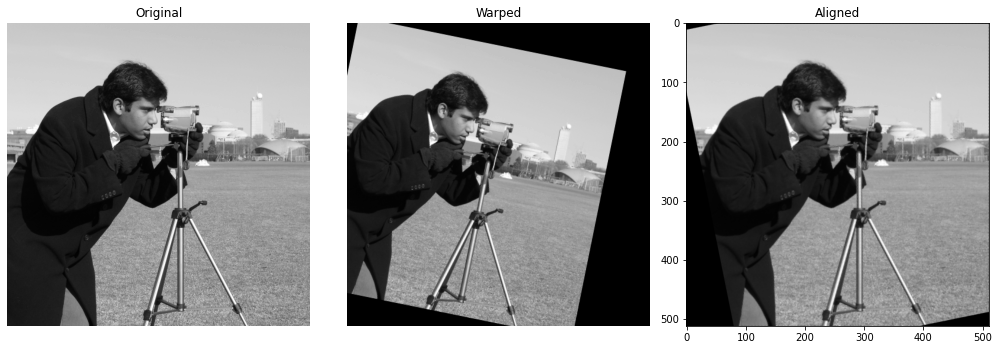

In [ ]:
inv_h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

img_aligned = transform.warp(img_warped, inv_h)

fig, ax = plt.subplots(1, 3, figsize=(14, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original'), ax[0].axis('off')
ax[1].imshow(img_warped, cmap='gray')
ax[1].set_title('Warped'), ax[1].axis('off')
ax[2].imshow(img_aligned, cmap='gray')
ax[2].set_title('Aligned'), ax[1].axis('off')
fig.tight_layout()
plt.show()

## Task 2.1: Break the algorithm

**Try other, more dramatic distortions** (get creative!). Can you **break the image matching algorithm** we just implemented?

# 3: Watershed segmentation

Adapted from [here](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py).

The **watershed** is a classical algorithm used for segmentation, that is, for separating different objects in an image.

Starting from user-defined markers, the watershed algorithm treats pixels values as a local topography (elevation). The algorithm floods basins from the markers until basins attributed to different markers meet on watershed lines. In many cases, markers are chosen as local minima of the image, from which basins are flooded.

In the example below, two overlapping circles are to be separated. To do so, one computes an image that is the distance to the background. The maxima of this distance (i.e., the minima of the opposite of the distance) are chosen as markers and the flooding of basins from such markers separates the two circles along a watershed line.

Let's first generate an initial image with two overlapping circles. The image is boolean, mimicking the result of a potential thresholding operation:

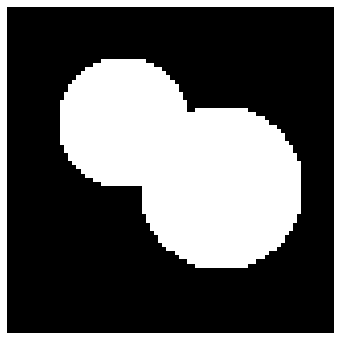

In [ ]:
from scipy import ndimage
from skimage import io, segmentation, feature
import matplotlib.pyplot as plt
import numpy as np

x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
img = np.logical_or(mask_circle1, mask_circle2)

plt.figure(figsize=(6, 6)) 
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

First, we need to apply the distance transform to the binary image:

In [ ]:
distance = ndimage.distance_transform_edt(img)

Next, we generate the markers as local maxima of the distance image (which is equivalent to generating the local minima of the -distance image):

In [ ]:
coords = feature.peak_local_max(distance, footprint=np.ones((3, 3)), labels=img)
distance[distance<0] = 0   # This is just to correct a bug in peak_local_max
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndimage.label(mask)

Finally, let's run the watershed algorithm using the dedicated function in `skimage.segmentation`:

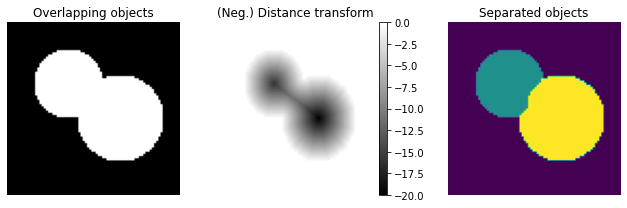

In [ ]:
labels = segmentation.watershed(-distance, markers, mask=img)

fig, ax = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects'), ax[0].axis('off')
pos = ax[1].imshow(-distance, cmap='gray')
ax[1].set_title('(Neg.) Distance transform')
ax[1].axis('off'), ax[1].set_aspect('auto')
ax[2].imshow(labels)
ax[2].set_title('Separated objects'), ax[2].axis('off')
fig.colorbar(pos, ax=ax[1])
fig.tight_layout()
plt.show()

# 4: Tracking through segmentation

In the previous lab tutorial, we learned a way to segment starfish out of a static image. However, **segmentation can be used also to track an object in a video sequence**: if instead of being given a static image of starfish, we were given a video, we could apply the segmentation workflow from before to each frame the video, providing a pixel-wise tracking of objects through the video sequence. Let's see how we can implement this in an example.

First we need to load the video. `OpenCV` provides some functionality to do this: however, to better handle the data we will convert it to a 4D `ndarray` of shape `[frameCount, frameHeight, frameWidth, nChannels=3]`. It's important to note that `OpenCV` loads colour data with BGR coding instead of the more common RGB, so we will perform a conversion to avoid surprises.

video shape = (300, 480, 640, 3)


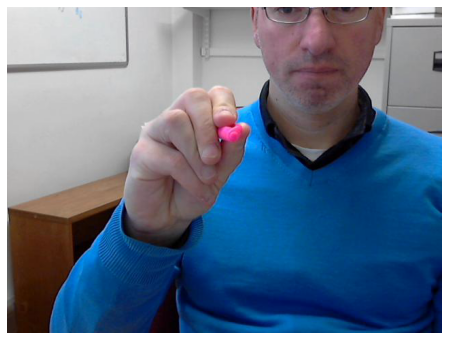

In [ ]:
from skimage.measure import label, regionprops
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

cap = cv2.VideoCapture(os.path.join(GOOGLE_DRIVE_PATH, 'GregPen.avi'))
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

video = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while fc < frameCount and ret:
    ret, video[fc] = cap.read()
    video[fc] = cv2.cvtColor(video[fc], cv2.COLOR_BGR2RGB)
    fc += 1

cap.release()

print('video shape =', video.shape)

# Show the 10th frame
plt.figure(figsize=(9, 6)) 
plt.imshow(video[9, :, :, :])
plt.axis('off')
plt.show()

Displaying videos in Colab is not straightforward, but using `matplotlib.animation` submodule will do the trick (have a look at the documentation to better understand how this works).

**Warning**: the next cell will require some time to execute.

In [ ]:
from matplotlib import rc
import matplotlib.animation as animation
rc('animation', html='jshtml')

fig, ax = plt.subplots()

def frame(i):
    ax.clear()
    ax.axis('off')
    fig.tight_layout()
    plot=ax.imshow(video[i, :, :, :])
    return plot

anim = animation.FuncAnimation(fig, frame, frames=100)
plt.close()
anim

Output hidden; open in https://colab.research.google.com to view.

Alright, now we have loaded our video, converted it into an easy-to-manage format, and we can display it. We have thus all the ingredients for the next task.

## Task 4.1: Track the pink marker

Write the code necessary to **track the centre of the pink marker in the video sequence**. To do this, you can use a similar approach to the one used for segmenting starfish in the past tutorial. In particular, you can **use the following channel-based ranges**: 

- $R>190$
- $40<G<120$
- $120<B<210$

Store the marker coordinates in the provided `marker_coord` array. (Tip: to detect the marker, it's advisable to select the region with highest area).

In [ ]:
marker_coord = np.zeros((frameCount, 2))

##############################################################################
# TODO: Track the pink marker                                                #
##############################################################################
for i in range(frameCount):
    img_seg = (video[i, :, :, 0] > 190) \
              & (video[i, :, :, 1] > 40) & (video[i, :, :, 1] < 120) \
              & (video[i, :, :, 2] > 120) & (video[i, :, :, 2] < 210)

    label_img = label(img_seg)
    regions = regionprops(label_img)
    sorted_regions = sorted(regions, key=lambda x: x.area, reverse=True)
    marker_coord[i, :] = sorted_regions[0].centroid
    
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

fig, ax = plt.subplots()

def frame(i):
    ax.clear()
    ax.axis('off')
    ax.plot(marker_coord[i, 1], marker_coord[i, 0], 'og')
    fig.tight_layout()
    plot=ax.imshow(video[i, :, :, :])
    return plot

anim = animation.FuncAnimation(fig, frame, frames=100)
plt.close()
anim